In [1]:
## Loding libraries
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
## Preprocecing ##
jh_dir = "../../COVID-19"
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [3]:
## Definitions ##

In [4]:
### dates ###
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-18')
upto = last-pd.Timedelta(days=2)
index= pd.date_range(start=epoch, end=upto)

In [19]:
### Fitting a model ###
def fit_and_infer(sm=None, data=None, country=None, population=None, detection_rate=1,
                  b_sigma_0=1, inits='random', iteration=10000, start=epoch, last=last):
    if data is None:
        C0 = confirmed.loc[start:last, country].values
        D0 = death.loc[start:last, country].values
        P = population
        data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'D0':D0, 
                'q0':detection_rate, 'b_sigma_0':b_sigma_0}
    fit = sm.sampling(data=data, iter=iteration, init=inits)
    print(fit)
    return az.from_pystan(fit, log_likelihood='log_lik')

In [6]:
### Extract data ###
def extract_var(var_name=None, data=None, start=epoch):
    d = data.posterior[var_name].stack(sample=('chain', 'draw')).values
    return pd.DataFrame(d, index=pd.date_range(start, end=start+pd.Timedelta(days=len(d)-1)))

In [7]:
### Drawing ###
def draw(data, index=index, name=None, line=None, label_name=None, value_name='value'):
    df = pd.DataFrame()
    dfs = []
    for label, samples in data.items():
        samples['Date'] = samples.index
        melted=pd.melt(samples, id_vars=['Date'])
        if label_name is not None:
            melted[label_name]=label
        dfs.append(melted)
    df = pd.concat(dfs)
    df = df.rename(columns={'value':value_name})
    if label_name is not None:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name, hue=label_name)
    else:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linestyle='--', linewidth=2, alpha=.7)
    g.savefig("{}.pdf".format(name))
    plt.show()

In [23]:
## Compile models ##
sm = pystan.StanModel(file="model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d846fe278209b62bff35f8ebed99a7c0 NOW.


In [12]:
## Model Validation ##

In [24]:
#### Constant parameters ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_sigma_0':0.1, 'q0':q}

data = simulate(0.07, 0.2, 100, 0.04, 0.001, 1200_0000, index)

infered = fit_and_infer(sm=sm, data=data)


Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      42.94    0.82  23.08  15.61  27.75  37.98  51.79  99.91    798   1.01
b_sigma      2.7e-3  6.3e-5 1.2e-3 9.9e-4 1.8e-3 2.5e-3 3.3e-3 5.7e-3    374   1.01
b[1]           0.07  7.4e-4   0.02   0.02   0.06   0.07   0.09   0.12   1021    1.0
b[2]           0.07  6.9e-4   0.02   0.03   0.06   0.07   0.09   0.12   1033    1.0
b[3]           0.08  6.7e-4   0.02   0.03   0.06   0.07   0.09   0.12   1026    1.0
b[4]           0.08  6.6e-4   0.02   0.04   0.06   0.07   0.09   0.12   1010    1.0
b[5]           0.08  6.3e-4   0.02   0.04   0.06   0.07   0.09   0.12   1031    1.0
b[6]           0.08  6.3e-4   0.02   0.04   0.06   0.08   0.09   0.12   1011    1.0
b[7]           0.08  6.2e-4   0.02   0.04   0.06   0.

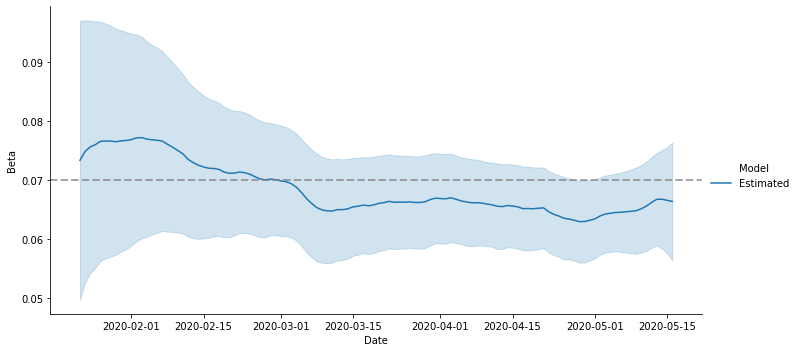

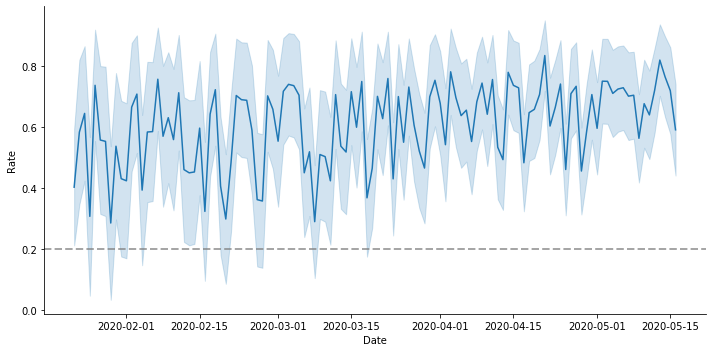

In [25]:
beta = extract_var(var_name='b', data=infered)
q = extract_var(var_name='q', data=infered)
draw({'Estimated':beta}, name='const_beta', line=0.07, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', label_name=None, value_name='Rate')

In [28]:
#### Step-like detection rate ####
from scipy.stats import poisson
def simulate(b, q1, q2, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    D_obs = [0]
    R_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_sigma_0':0.1, 'q0':q1}, np.array(q)

data, q_true = simulate(0.07, 1, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered = fit_and_infer(sm=sm, data=data)


Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     235.79     6.0 127.26 104.14 147.79 198.21 281.97 583.49    449   1.01
b_sigma      3.1e-3  4.2e-5 1.1e-3 1.4e-3 2.4e-3 3.0e-3 3.8e-3 5.6e-3    636    1.0
b[1]           0.04  6.7e-4   0.02 4.1e-3   0.03   0.04   0.06   0.09   1235    1.0
b[2]           0.05  7.3e-4   0.02   0.02   0.04   0.05   0.07   0.09    779   1.01
b[3]           0.05  7.3e-4   0.02   0.02   0.04   0.05   0.07   0.09    756   1.01
b[4]           0.06  7.4e-4   0.02   0.02   0.04   0.06   0.07   0.09    723   1.01
b[5]           0.06  7.4e-4   0.02   0.02   0.04   0.06   0.07   0.09    704   1.01
b[6]           0.06  7.4e-4   0.02   0.02   0.04   0.06   0.07    0.1    707   1.01
b[7]           0.06  7.2e-4   0.02   0.02   0.05   0.

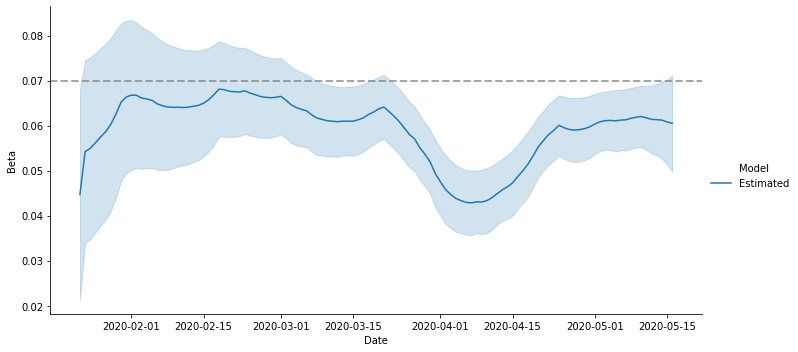

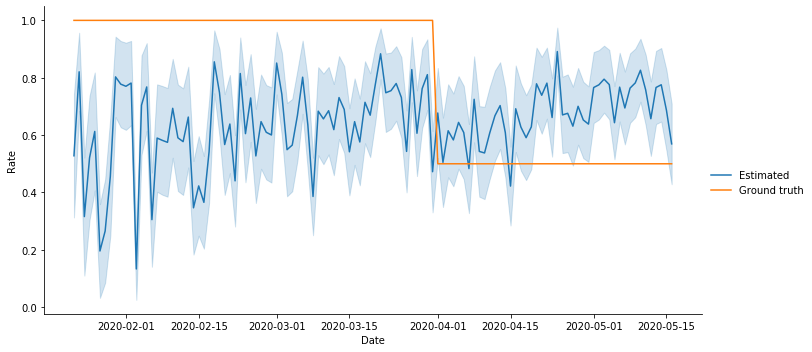

In [29]:
beta = extract_var(var_name='b', data=infered)
q = extract_var(var_name='q', data=infered)
                     
draw({'Estimated':beta}, name='step_beta', 
     label_name='Model', value_name='Beta', line=0.07)

q_true = pd.DataFrame(q_true, index)
draw({'Estimated':q, 'Ground truth':q_true}, name='step_q', value_name='Rate', label_name='')

In [30]:
#### Changing beta ####
from scipy.stats import poisson
def simulate(b0, b1, q0, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    q = [q0]
    D_obs = [0]
    R_obs = [0]
    b = [b0]
    for t in index:
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
        q.append(q0 + 0.05*np.random.randn(1)[0])
        b.append(b[-1] - b1)
 
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_sigma_0':1, 'q0':q0}, np.array(q), np.array(b)
data, q_true, b_true = simulate(0.16, 0.001, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered = fit_and_infer(sm=sm, data=data)


Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     120.79    0.97   42.7  63.13  90.49 112.86 142.02 224.66   1953    1.0
b_sigma      3.1e-3  3.1e-5 9.1e-4 1.7e-3 2.5e-3 3.0e-3 3.7e-3 5.3e-3    876    1.0
b[1]           0.13  4.4e-4   0.02   0.08   0.11   0.13   0.14   0.18   2871    1.0
b[2]           0.13  4.3e-4   0.02   0.08   0.12   0.13   0.14   0.17   2797    1.0
b[3]           0.13  4.3e-4   0.02   0.09   0.12   0.13   0.14   0.17   2693    1.0
b[4]           0.13  4.2e-4   0.02   0.09   0.12   0.13   0.15   0.17   2590    1.0
b[5]           0.13  4.1e-4   0.02   0.09   0.12   0.13   0.15   0.17   2525    1.0
b[6]           0.13  4.0e-4   0.02   0.09   0.12   0.13   0.15   0.17   2455    1.0
b[7]           0.13  3.9e-4   0.02   0.09   0.12   0.

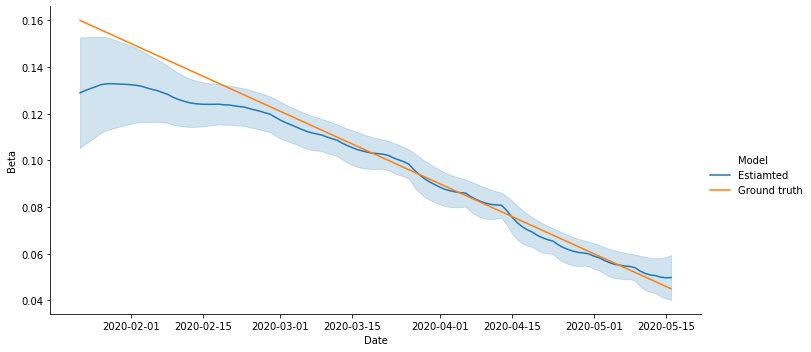

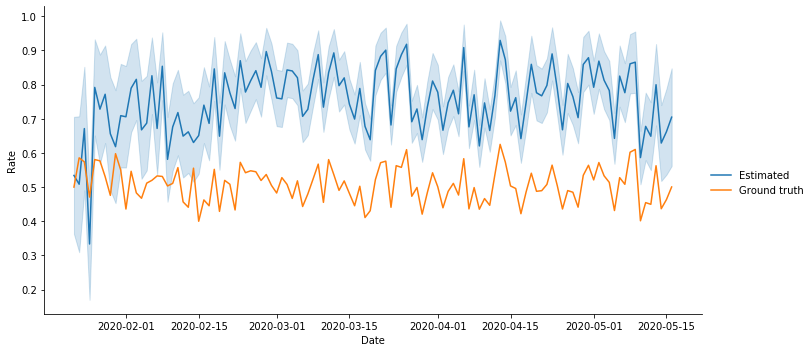

In [32]:
beta = extract_var('b', infered)
q = extract_var('q', infered)
b = extract_var('b', infered)
                  
b_true = pd.DataFrame(b_true[:-1], index)
draw({'Estiamted':beta, 'Ground truth':b_true}, 
     name='trend_beta', label_name='Model', value_name='Beta')

q_true = pd.DataFrame(q_true[:-1], index)
draw({'Estimated':q, 'Ground truth':q_true}, name='trend_q', value_name='Rate', label_name='')

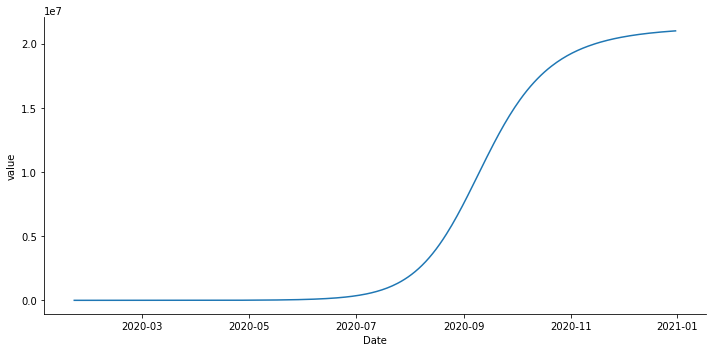

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf        1.9     1.1   1.56   0.24   0.45    1.6    3.4   4.18      2 243.84
b_sigma         0.2    0.07    0.1   0.03   0.11   0.25   0.29   0.34      2   4.54
b[1]           2.35     0.9   1.28   0.46   1.11   2.58   3.58    3.6      2  46.72
b[2]           0.46    0.16   0.23   0.22   0.25   0.44   0.69   0.76      2 116.54
b[3]           1.74    1.18   1.67   0.18   0.59   1.12   2.94   4.63      2  68.07
b[4]           1.32    0.95   1.34    0.2   0.31   0.77   2.42   3.61      2 204.45
b[5]           0.92    0.55   0.77   0.29   0.41   0.56   1.51   2.25      2 190.51
b[6]           1.13    1.15   1.63   0.16   0.19    0.2   2.24    4.0      2 181.72
b[7]           0.55    0.28    0.4   0.24   0.26   0.

In [33]:
# #### Saturate ####
# from scipy.stats import poisson
# def simulate(b, q, init_inf, a, d, P, index):
#     C = init_inf
#     I = init_inf
#     R = 0
#     D = 0
#     C_obs = [poisson.rvs(init_inf*q)]
#     R_obs = [0]
#     D_obs = [0]
#     for t in index:
#         NI = poisson.rvs(b*I*(1-C/P))
#         NR = poisson.rvs(a*I)
#         ND = poisson.rvs(d*I)
#         I = I + NI - NR - ND
#         C = C + NI
#         R = R + NR
#         D = ND
#         C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
#         D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
#         R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
#     return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_sigma_0':1, 'q0':q}

# index=pd.date_range(start=epoch, end=pd.to_datetime('2020-12-31'))
# data = simulate(0.10, 0.2, 100, 0.04, 0.001, 12000_0000,index)
# C0 = pd.DataFrame(data['C0'][:-1], index)
# draw({'Cumulative':C0})

# infered = fit_and_infer(sm=sm, data=data)

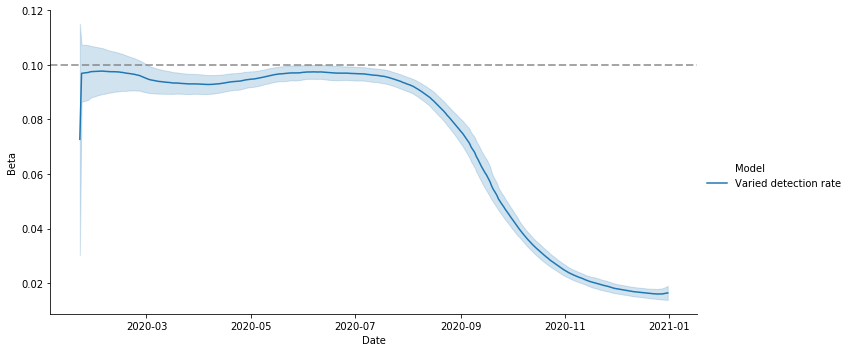

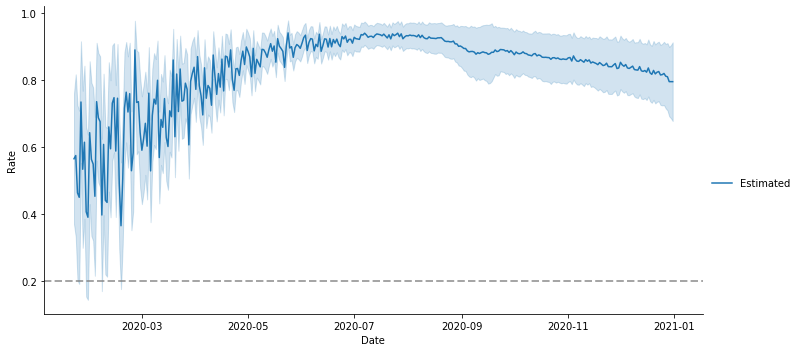

In [17]:
# beta_const_q = extract_var('b', infered_const_q)
# beta = extract_var('b', infered_every)
# q = extract_var('q', infered_every)
# draw({'Varied detection rate':beta}, name='saturate_beta', line=0.10, 
#      label_name='Model', value_name='Beta')
# draw({'Estimated':q}, line=0.2, name='saturate_q', value_name='Rate', label_name='')

In [35]:
## Analysis ##
iteration = 10000

In [36]:
### Japanese case ###
P = 126_500_000
infer = fit_and_infer(sm=sm, country='Japan', population=P, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       42.6    0.98  29.93   7.37  21.81  35.71  55.23 119.82    933    1.0
b_sigma      8.8e-3  7.9e-5 2.4e-3 5.0e-3 7.1e-3 8.6e-3   0.01   0.01    902   1.01
b[1]           0.03  8.1e-4   0.04 1.6e-3 9.1e-3   0.02   0.04   0.14   2077    1.0
b[2]           0.05  9.5e-4   0.04 4.5e-3   0.02   0.03   0.06   0.15   1723    1.0
b[3]           0.06  1.0e-3   0.04 7.8e-3   0.03   0.04   0.08   0.16   1598    1.0
b[4]           0.07  1.0e-3   0.04   0.01   0.04   0.06   0.09   0.16   1541    1.0
b[5]           0.07  1.0e-3   0.04   0.02   0.04   0.06   0.09   0.16   1481    1.0
b[6]           0.08  9.9e-4   0.04   0.02   0.05   0.07    0.1   0.17   1471    1.0
b[7]           0.08  9.9e-4   0.04   0.02   0.05   0.

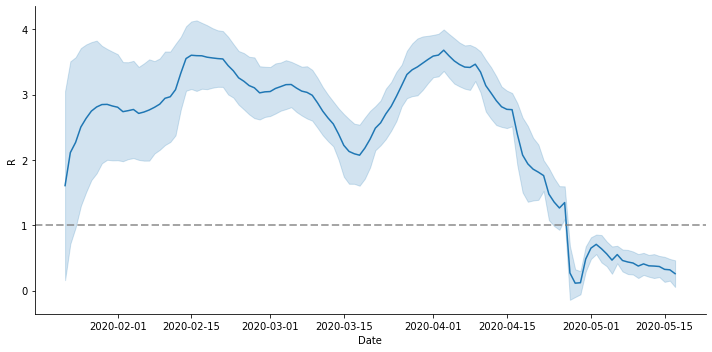

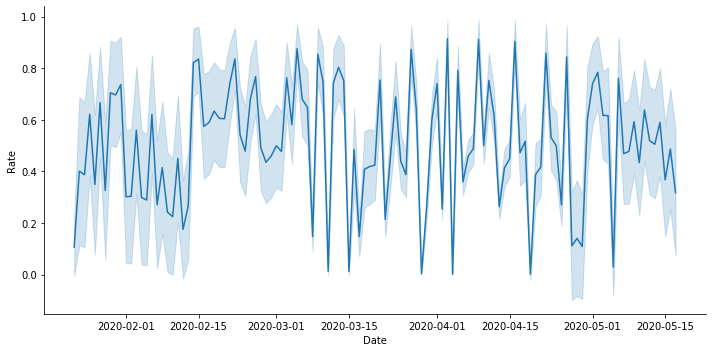

In [37]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_J = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_J}, line=1, name='R_Japan', value_name='R')
draw({'Detection rate':q}, name='q_Japan', value_name='Rate')

In [38]:
#### Sensiticity Analysis ####
infer_s = fit_and_infer(sm=sm, country='Japan', population=P, iteration=iteration, b_sigma_0=0.1)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      43.95    1.04  30.83   6.81  22.59  37.14  57.42 119.94    875    1.0
b_sigma      8.9e-3  7.5e-5 2.3e-3 5.2e-3 7.3e-3 8.7e-3   0.01   0.01    963    1.0
b[1]           0.03  9.7e-4   0.04 1.6e-3 9.3e-3   0.02   0.04   0.14   1461    1.0
b[2]           0.04  1.1e-3   0.04 4.4e-3   0.02   0.03   0.06   0.15   1360    1.0
b[3]           0.05  1.1e-3   0.04 8.2e-3   0.03   0.04   0.07   0.16   1219    1.0
b[4]           0.06  1.1e-3   0.04   0.01   0.04   0.06   0.08   0.16   1278    1.0
b[5]           0.07  1.1e-3   0.04   0.02   0.04   0.06   0.09   0.17   1209    1.0
b[6]           0.08  1.1e-3   0.04   0.02   0.05   0.07    0.1   0.17   1159    1.0
b[7]           0.08  1.1e-3   0.04   0.02   0.05   0.

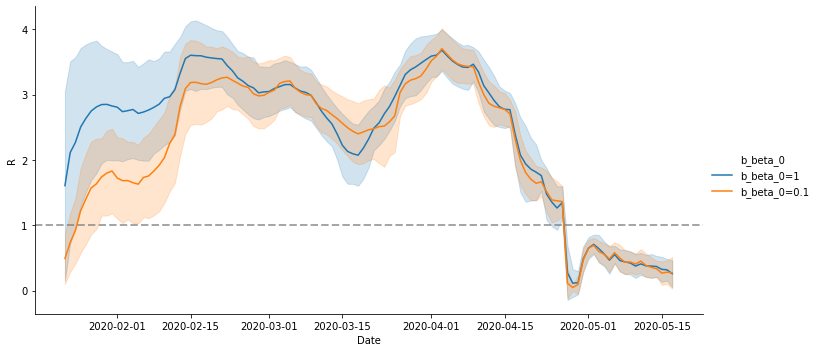

In [39]:
infer = infer_s
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_JS = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)
draw({'b_beta_0=1':R_J, 'b_beta_0=0.1':R_JS}, line=1, name='Sensitivity', 
     value_name='R', label_name='b_beta_0')

In [40]:
### China ###
P = 1_393_000_000
country='China'
infer = fit_and_infer(sm=sm, country=country, population=P, iteration=iteration)

Inference for Stan model: anon_model_d846fe278209b62bff35f8ebed99a7c0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       6.49    0.94   1.33    4.3   5.33   6.94   7.56    7.8      2 374.85
b_sigma        1.28    0.75   1.07   0.19   0.22   1.18   2.35   2.55      2 1639.8
b[1]           1.94    1.77    2.5   0.34   0.42   0.57   3.72   6.27      2 2456.5
b[2]           2.68    1.32   1.87   0.88   0.99   2.16   4.47   5.51      2 1308.2
b[3]           3.15    1.35   1.91   0.38   1.58   3.24    4.7   5.77      2 1137.8
b[4]           1.61    0.65   0.92   0.87   0.97    1.2   2.33   3.19      2 1075.5
b[5]           1.46    1.49    2.1   0.14   0.14   0.31   3.01    5.1      2 2917.0
b[6]           2.52    1.61   2.28   0.18   0.24    2.4   4.82   5.08      2 1247.4
b[7]           1.59    0.94   1.32   0.29   0.63   1.

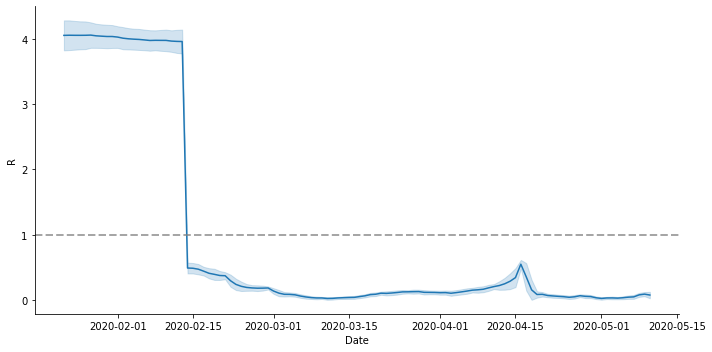

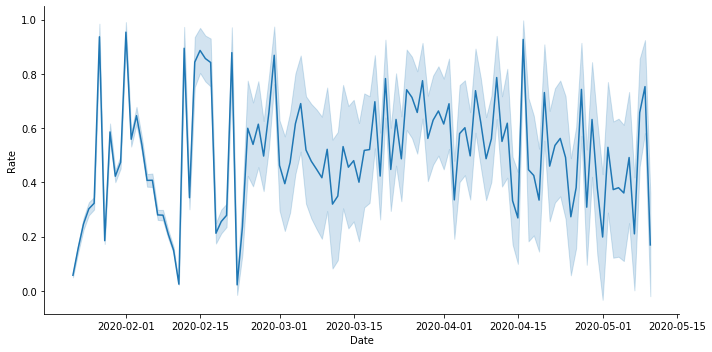

In [24]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_C = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_C}, line=1, name='R_China', value_name='R')
draw({'Detection rate':q}, name='q_China', value_name='Rate')

In [25]:
### US ###
P = 327_200_000
country='US'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     420.49    0.15  21.88  378.7 405.74 420.15 435.06 464.02  20662    1.0
b              0.08  5.3e-7 7.6e-5   0.08   0.08   0.08   0.08   0.08  20870    1.0
q               1.0  8.3e-8 1.3e-5    1.0    1.0    1.0    1.0    1.0  23333    1.0
NI[1]         34.87    0.04   5.67  23.89  31.02  34.82  38.75  46.06  20696    1.0
NI[2]         38.67    0.04   5.64  27.72  34.89  38.64  42.44  49.84  20450    1.0
NI[3]         40.83    0.04   5.89  29.48  36.78  40.74  44.79  52.49  20746    1.0
NI[4]         46.38    0.04   5.95  34.73  42.39   46.4  50.39  58.01  19971    1.0
NI[5]         47.73    0.04   6.21  35.78  43.47  47.69   51.9  60.14  21154    1.0
NI[6]         51.48    0.04   6.31   39.2  47.24  51.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.51  6.5e-3   0.83   0.38   0.92   1.35   1.92    3.6  16263    1.0
b_beta         0.03  4.7e-5 4.4e-3   0.02   0.02   0.03   0.03   0.04   8646    1.0
b[1]           0.05  4.7e-4   0.05 2.5e-3   0.02   0.04   0.07   0.18  10602    1.0
b[2]           0.09  5.5e-4   0.05   0.02   0.05   0.08   0.12   0.22   9063    1.0
b[3]            0.1  5.9e-4   0.05   0.02   0.07    0.1   0.14   0.23   8324    1.0
b[4]           0.12  5.7e-4   0.05   0.04   0.08   0.11   0.15   0.24   8440    1.0
b[5]           0.12  6.1e-4   0.05   0.03   0.08   0.11   0.15   0.24   7480    1.0
b[6]           0.12  6.6e-4   0.05   0.03   0.08   0.11   0.15   0.24   6588    1.0
b[7]           0.12  6.6e-4   0.05   0.03   0.08   0.

Inference for Stan model: anon_model_e7746764851833e7f3347e375cd9ca44.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf        3.2    0.04   2.74   0.67    1.6   2.49   3.88  10.18   4148    1.0
b_beta         0.01  7.8e-5 3.2e-3 9.0e-3   0.01   0.01   0.02   0.02   1716    1.0
b[1]           0.05  5.9e-4   0.05 1.9e-3   0.02   0.03   0.07   0.17   6263    1.0
b[2]           0.08  6.0e-4   0.05   0.01   0.04   0.07    0.1   0.19   6307    1.0
b[3]           0.09  5.9e-4   0.05   0.02   0.06   0.08   0.12    0.2   6222    1.0
b[4]            0.1  5.7e-4   0.04   0.03   0.07    0.1   0.13    0.2   6099    1.0
b[5]           0.11  5.8e-4   0.04   0.03   0.07    0.1   0.13    0.2   5764    1.0
b[6]           0.11  5.8e-4   0.04   0.04   0.08    0.1   0.13    0.2   5513    1.0
b[7]           0.11  5.8e-4   0.04   0.04   0.08   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one 

         rank      loo    p_loo    d_loo       weight       se      dse  \
Varied_q    0  1073.14  91.3052        0            1  14430.1        0   
Const_q     1  1131.77  115.129  58.6345  2.53878e-07  68.6388  21.1561   
Const       2   146872  14052.8   145799            0   60.324  13990.6   

         warning loo_scale  
Varied_q    True  deviance  
Const_q     True  deviance  
Const       True  deviance  
         rank     waic   p_waic   d_waic       weight       se      dse  \
Varied_q    0  1008.04  58.7534        0     0.999997  24228.4        0   
Const_q     1  1062.62  80.5518  54.5834  2.68104e-06  64.1098  23.3951   
Const       2   223923  52578.1   222915            0  55.9468  23612.4   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


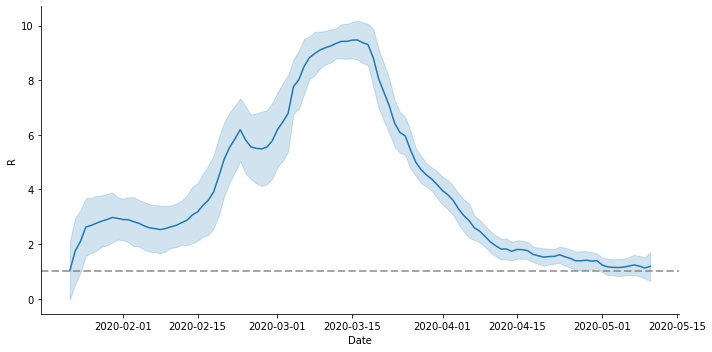

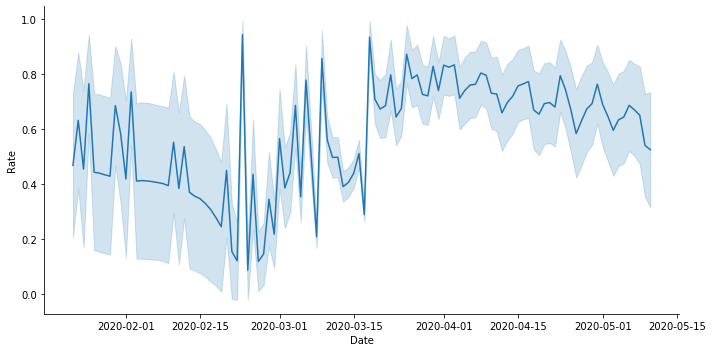

In [26]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_US = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_US}, line=1, name='R_US', value_name='R')
draw({'Detection rate':q}, name='q_US', value_name='Rate')

In [27]:
### Italy ###
P = 60_360_000
country='Italy'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     1190.1    0.27   38.1 1115.8 1164.2 1190.0 1216.2 1264.9  20552    1.0
b              0.07  1.0e-6 1.5e-4   0.06   0.06   0.07   0.07   0.07  22082    1.0
q               1.0  2.5e-7 4.2e-5    1.0    1.0    1.0    1.0    1.0  26932    1.0
NI[1]         80.33    0.05   8.49  63.82  74.59  80.38  86.04  97.34  24281    1.0
NI[2]         85.47    0.06   8.83  68.28  79.52  85.49  91.38 102.79  23510    1.0
NI[3]         91.11    0.06   8.82  73.61  85.19  91.13  97.01 108.41  22980    1.0
NI[4]          97.1    0.06   8.91  79.64  91.04  97.14 103.07 114.45  25413    1.0
NI[5]        103.41    0.06   9.13  85.69  97.23 103.33 109.57 121.46  23692    1.0
NI[6]        111.01    0.06   9.28  92.59 104.82 111.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.75    0.05   0.99   0.42   1.04   1.55   2.24   4.21    356   1.01
b_beta         0.01  3.0e-5 2.3e-3 9.9e-3   0.01   0.01   0.02   0.02   5924    1.0
b[1]           0.02  2.4e-4   0.02 9.3e-4 7.6e-3   0.02   0.03   0.08   7152    1.0
b[2]           0.03  4.4e-4   0.02 2.6e-3   0.02   0.03   0.04    0.1   3174    1.0
b[3]           0.04  5.7e-4   0.03 4.6e-3   0.02   0.04   0.06   0.11   2413    1.0
b[4]           0.05  6.4e-4   0.03 6.9e-3   0.03   0.05   0.07   0.12   2220   1.01
b[5]           0.06  9.5e-4   0.03 9.7e-3   0.04   0.05   0.07   0.13   1079   1.01
b[6]           0.06  1.2e-3   0.03   0.01   0.04   0.06   0.08   0.14    669   1.01
b[7]           0.07  1.4e-3   0.03   0.01   0.04   0.

Inference for Stan model: anon_model_e7746764851833e7f3347e375cd9ca44.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.52    0.09   2.93   0.45   1.16   1.84   2.94   8.44   1105    1.0
b_beta       9.1e-3  8.4e-5 2.6e-3 4.8e-3 7.3e-3 8.9e-3   0.01   0.02    963   1.01
b[1]           0.04  2.8e-3   0.07 6.5e-4 5.8e-3   0.01   0.03    0.3    635   1.01
b[2]           0.06  3.4e-3   0.09 2.0e-3   0.01   0.03   0.06   0.34    670    1.0
b[3]           0.09  4.3e-3    0.1 4.0e-3   0.02   0.04    0.1   0.37    607    1.0
b[4]           0.11  4.6e-3   0.11 6.2e-3   0.03   0.06   0.14   0.39    600    1.0
b[5]           0.13  5.1e-3   0.12 9.4e-3   0.04   0.07   0.21    0.4    580    1.0
b[6]           0.16  5.7e-3   0.13   0.02   0.05    0.1   0.28   0.42    519   1.01
b[7]           0.17  5.9e-3   0.13   0.02   0.06   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:

         rank      loo    p_loo    d_loo    weight       se      dse warning  \
Varied_q    0  989.929  85.5482        0  0.535769  4452.54        0    True   
Const_q     1  994.347   86.783   4.4175  0.464231  45.3811   20.242    True   
Const       2  43724.5  6770.77  42734.6         0  39.9223  4492.52    True   

         loo_scale  
Varied_q  deviance  
Const_q   deviance  
Const     deviance  
         rank     waic   p_waic   d_waic   weight       se      dse warning  \
Varied_q    0  918.949  50.0581        0  0.74087  6741.48        0    True   
Const_q     1   929.97  54.5945  11.0206  0.25913  41.1766  15.9621    True   
Const       2  60707.3  15262.1  59788.3        0  37.7892  6796.55    True   

         waic_scale  
Varied_q   deviance  
Const_q    deviance  
Const      deviance  


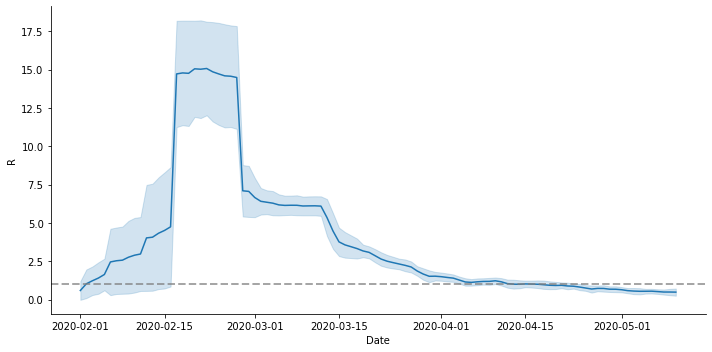

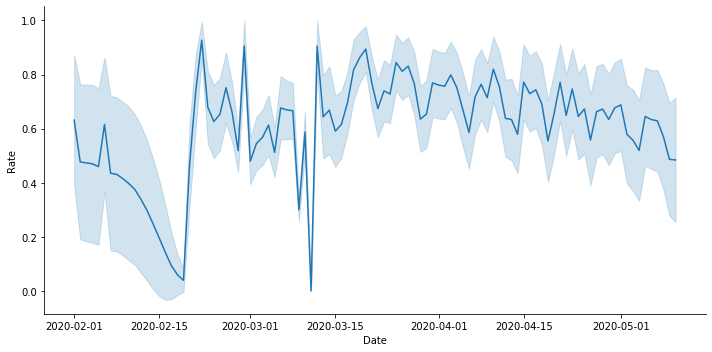

In [28]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_I = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_I}, line=1, name='R_Italy', value_name='R')
draw({'Detection rate':q}, name='q_Italy', value_name='Rate')

In [43]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration, b_beta_0=5)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     152.78    0.07  14.26  125.7 143.01 152.39 162.14 181.94  37573    1.0
b              0.06  3.8e-6 7.0e-4   0.06   0.06   0.06   0.06   0.06  33622    1.0
q               1.0  2.1e-6 3.6e-4    1.0    1.0    1.0    1.0    1.0  30681    1.0
NI[1]          9.69    0.02   2.98   3.89   7.66   9.69   11.7   15.6  22325    1.0
NI[2]         11.15    0.02   2.91   5.55   9.15  11.12   13.1  16.95  34024    1.0
NI[3]         10.93    0.02   3.08   4.86   8.85  10.92   13.0  16.98  29486    1.0
NI[4]         12.42    0.02   3.01   6.66  10.35  12.41  14.44  18.37  34546    1.0
NI[5]         13.08    0.02   3.07   7.17  10.96  13.06  15.13  19.21  34175    1.0
NI[6]         13.07    0.02   3.21   6.78   10.9  13.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.52    0.02   1.42   0.66   1.51   2.22   3.21   6.09   7785    1.0
b_beta       8.5e-3  2.4e-5 1.5e-3 5.9e-3 7.4e-3 8.4e-3 9.4e-3   0.01   4109    1.0
b[1]           0.06  1.1e-3   0.06 1.1e-3   0.01   0.04    0.1   0.19   2353    1.0
b[2]           0.09  9.3e-4   0.05   0.01   0.05   0.09   0.13    0.2   3008    1.0
b[3]            0.1  8.4e-4   0.05   0.02   0.07    0.1   0.13    0.2   3097    1.0
b[4]           0.11  7.3e-4   0.04   0.03   0.08   0.11   0.14    0.2   3407    1.0
b[5]           0.12  6.7e-4   0.04   0.04   0.09   0.11   0.14    0.2   3589    1.0
b[6]           0.12  6.3e-4   0.04   0.05   0.09   0.12   0.14    0.2   3687    1.0
b[7]           0.12  5.8e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_e7746764851833e7f3347e375cd9ca44.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     188.99  223.05 412.27   0.36   0.99   1.63   4.37 1367.3      3   2.37
b_beta       3.1e-3  1.9e-4 1.2e-3 1.2e-3 2.3e-3 2.9e-3 3.7e-3 5.7e-3     38   1.17
b[1]           0.12    0.05   0.13 2.2e-4 2.4e-3   0.03   0.26    0.3      7   1.32
b[2]           0.19    0.07   0.11 1.1e-3   0.03   0.24   0.27   0.31      3   2.14
b[3]            0.2    0.07   0.11 1.0e-3   0.12   0.25   0.27   0.31      2   2.94
b[4]            0.2    0.07   0.11 1.6e-3   0.14   0.25   0.27   0.31      2   3.24
b[5]            0.2    0.07   0.11 1.7e-3   0.14   0.25   0.27   0.31      2   3.28
b[6]            0.2    0.07   0.11 1.3e-3   0.14   0.25   0.27   0.31      2   3.43
b[7]            0.2    0.07   0.11 1.7e-3   0.14   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with 

         rank      loo    p_loo    d_loo     weight       se      dse warning  \
Varied_q    0  771.985  89.1419        0   0.917255  1198.97        0    True   
Const_q     1  802.245  95.2965  30.2601  0.0827453  39.6919  26.5315    True   
Const       2  7173.56   1357.5  6401.57          0  27.6857  1256.78    True   

         loo_scale  
Varied_q  deviance  
Const_q   deviance  
Const     deviance  
         rank     waic   p_waic   d_waic      weight       se      dse  \
Varied_q    0  701.531  53.9145        0    0.997585  1542.45        0   
Const_q     1  748.521  68.4343  46.9905  0.00241537  38.5031   26.713   
Const       2  7900.53  1720.99     7199           0  26.4681  1552.14   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


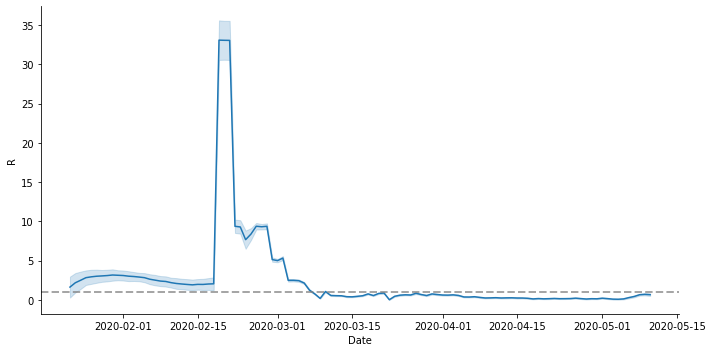

In [30]:
beta = extract_var(var_name='b', data=infer_const_q)
C = extract_var(var_name='C', data=infer_const_q)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K}, line=1, name='R_Korea', value_name='R')

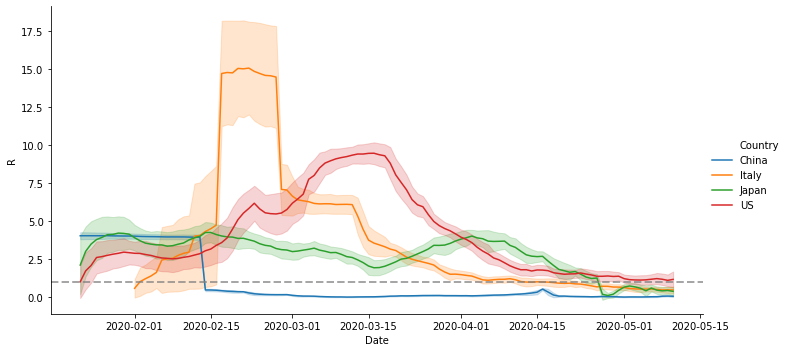

In [31]:
draw({'China':R_C, 'Italy':R_I, 'Japan':R_J, 'US':R_US}, line=1, name='R_multi', value_name='R', label_name='Country')

In [32]:
### Sweden ###
P = 10_230_000
country='Sweden'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      34.09    0.04   6.07  22.95  29.91  33.81   38.0  46.65  30012    1.0
b              0.08  3.4e-6 5.3e-4   0.08   0.08   0.08   0.08   0.08  24990    1.0
q               1.0  4.7e-6 8.6e-4    1.0    1.0    1.0    1.0    1.0  33740    1.0
NI[1]          2.81    0.01   1.44   0.32   1.74   2.74   3.76   5.81  19200    1.0
NI[2]           3.0    0.01   1.47    0.4   1.92   2.93   3.96   6.05  19213    1.0
NI[3]           3.2    0.01   1.53   0.48   2.09   3.14   4.21   6.37  18396    1.0
NI[4]          3.44    0.01   1.57   0.57   2.31   3.38   4.51   6.68  18881    1.0
NI[5]          3.63    0.01   1.66   0.59   2.45   3.58   4.73    7.1  17661    1.0
NI[6]          3.93    0.01    1.7   0.77   2.73   3.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       0.67  3.9e-3   0.48   0.07   0.31   0.56   0.91   1.89  15709    1.0
b_beta         0.02  3.8e-5 3.5e-3   0.02   0.02   0.02   0.02   0.03   8211    1.0
b[1]           0.03  1.9e-4   0.02 1.1e-3   0.01   0.02   0.04   0.09  15939    1.0
b[2]           0.04  2.7e-4   0.03 3.0e-3   0.02   0.04   0.06   0.12  12655    1.0
b[3]           0.05  3.3e-4   0.03 3.8e-3   0.03   0.04   0.07   0.13  10244    1.0
b[4]           0.06  3.8e-4   0.04 5.7e-3   0.03   0.05   0.08   0.15   9002    1.0
b[5]           0.06  4.3e-4   0.04 7.3e-3   0.03   0.06   0.08   0.15   8086    1.0
b[6]           0.07  4.7e-4   0.04 8.0e-3   0.04   0.06   0.09   0.16   7422    1.0
b[7]           0.07  5.1e-4   0.04 7.9e-3   0.04   0.

Inference for Stan model: anon_model_e7746764851833e7f3347e375cd9ca44.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.28    0.01   0.98   0.18   0.63   1.05   1.65   3.77   8811    1.0
b_beta         0.01  7.2e-5 3.1e-3 6.7e-3 9.9e-3   0.01   0.01   0.02   1810    1.0
b[1]           0.02  3.1e-4   0.02 8.1e-4 6.9e-3   0.01   0.03   0.09   5685    1.0
b[2]           0.03  4.3e-4   0.03 2.1e-3   0.01   0.03   0.05   0.11   4591    1.0
b[3]           0.04  5.3e-4   0.03 3.8e-3   0.02   0.04   0.06   0.13   3743    1.0
b[4]           0.05  5.8e-4   0.04 6.6e-3   0.03   0.04   0.07   0.14   3666    1.0
b[5]           0.06  7.2e-4   0.04 8.4e-3   0.03   0.05   0.08   0.15   2798    1.0
b[6]           0.07  7.8e-4   0.04   0.01   0.04   0.06   0.09   0.16   2576    1.0
b[7]           0.07  8.5e-4   0.04   0.01   0.04   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one 

         rank      loo    p_loo    d_loo       weight       se      dse  \
Varied_q    0  740.518  70.6787        0            1  329.092        0   
Const_q     1   818.13  97.9629  77.6124  6.56645e-09  51.9308  26.5933   
Const       2   3470.5  790.863  2729.98            0  41.0105  333.341   

         warning loo_scale  
Varied_q    True  deviance  
Const_q     True  deviance  
Const       True  deviance  
         rank     waic   p_waic   d_waic       weight       se      dse  \
Varied_q    0  683.517  42.1781        0            1  372.822        0   
Const_q     1  755.625  66.7101   72.108  1.14783e-07  46.7822  26.3027   
Const       2  3581.03   846.13  2897.52            0  37.0132  382.776   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


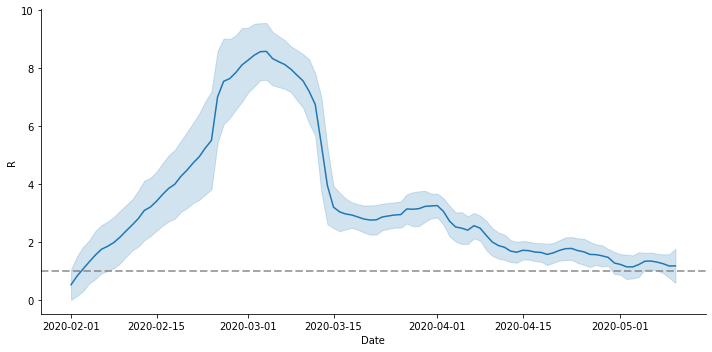

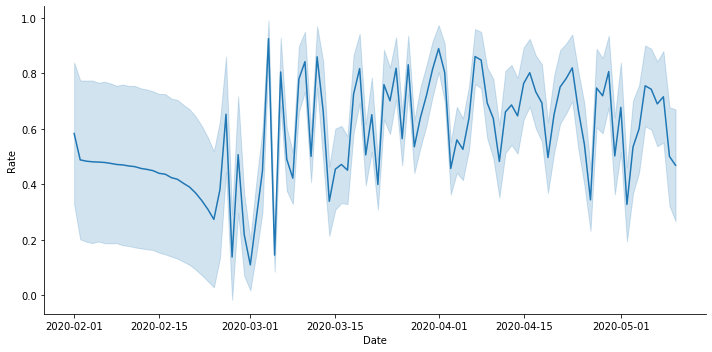

In [33]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_S = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_S}, line=1, name='R_Sweden', value_name='R')
draw({'Detection rate':q}, name='q_Sweden', value_name='Rate')

In [34]:
### Denmark ###
P = 5_806_000
country='Denmark'
start=pd.to_datetime('2020-03-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='loo'))
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}, ic='waic'))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    290.87    0.13   17.5 257.34 278.84 290.65 302.46 326.33  16846    1.0
b             0.07  5.5e-6 7.5e-4   0.07   0.07   0.07   0.07   0.07  18848    1.0
q              1.0  8.7e-6 1.4e-3   0.99    1.0    1.0    1.0    1.0  25247    1.0
NI[1]        19.99    0.03   4.31   11.6  17.05  19.99  22.89  28.43  20069    1.0
NI[2]        23.06    0.03   4.21   14.9  20.15  23.06   25.9  31.34  22544    1.0
NI[3]        26.59    0.03   4.14  18.69  23.76  26.52  29.42  34.83  23488    1.0
NI[4]         24.3    0.03   4.47  15.51  21.29  24.31  27.32  33.15  20973    1.0
NI[5]        34.01    0.03   4.08  26.24  31.17  33.95  36.74  42.14  23801    1.0
NI[6]        27.64    0.03   4.67  18.37  24.51  27.65  30.82 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      2.96    0.08   1.72    0.8    1.7   2.55   3.82    7.2    432   1.01
b_beta        0.01  1.1e-4 2.7e-3 8.1e-3   0.01   0.01   0.01   0.02    652    1.0
b[1]          0.25    0.03   0.32 9.5e-4 9.8e-3   0.05   0.42   1.04    105   1.03
b[2]           0.6    0.03   0.35   0.03   0.33   0.51   0.91   1.27    156   1.03
b[3]          0.64    0.03   0.34   0.16   0.36   0.55   0.94   1.33    156   1.02
b[4]          0.65    0.03   0.34   0.17   0.36   0.55   0.94   1.33    155   1.02
b[5]          0.67    0.03   0.34    0.2   0.38   0.57   0.95   1.38    154   1.01
b[6]          0.67    0.03   0.34   0.19   0.38   0.57   0.96   1.39    153   1.01
b[7]          0.99    0.04   0.44   0.31   0.58   0.98   1.35 

Inference for Stan model: anon_model_e7746764851833e7f3347e375cd9ca44.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.0    0.17   3.46    1.5   2.95   4.24    6.0  13.31    406   1.02
b_beta      7.7e-3  1.2e-4 2.3e-3 4.2e-3 6.1e-3 7.4e-3 8.9e-3   0.01    380   1.01
b[1]           0.4    0.12   0.35 6.7e-4 7.6e-3   0.59   0.71   0.85      9   1.46
b[2]           0.7  4.2e-3   0.09   0.53   0.64    0.7   0.76   0.89    497    1.0
b[3]           0.7  4.1e-3   0.09   0.53   0.64    0.7   0.76   0.89    495    1.0
b[4]          0.71  4.1e-3   0.09   0.53   0.64    0.7   0.76   0.89    479    1.0
b[5]          0.71  4.1e-3   0.09   0.54   0.65    0.7   0.76   0.89    477    1.0
b[6]          0.71  4.1e-3   0.09   0.54   0.65    0.7   0.76   0.89    471    1.0
b[7]          0.71  4.1e-3   0.09   0.54   0.65    0.7   0.76 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one 

         rank      loo    p_loo    d_loo        weight       se      dse  \
Varied_q    0  627.153  61.7025        0      0.999595  251.814        0   
Const_q     1  682.182  85.1857  55.0291   0.000404888  29.3373  26.9103   
Const       2  2404.58  527.984  1777.42  1.11757e-237  13.8015  255.983   

         warning loo_scale  
Varied_q    True  deviance  
Const_q     True  deviance  
Const       True  deviance  
         rank     waic   p_waic   d_waic        weight       se      dse  \
Varied_q    0  575.692   35.972        0      0.999948  268.024        0   
Const_q     1  639.786  63.9874  64.0935   5.23195e-05  32.1221  31.6033   
Const       2  2404.38  527.888  1828.69  3.15237e-244   11.852  271.735   

         warning waic_scale  
Varied_q    True   deviance  
Const_q     True   deviance  
Const       True   deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


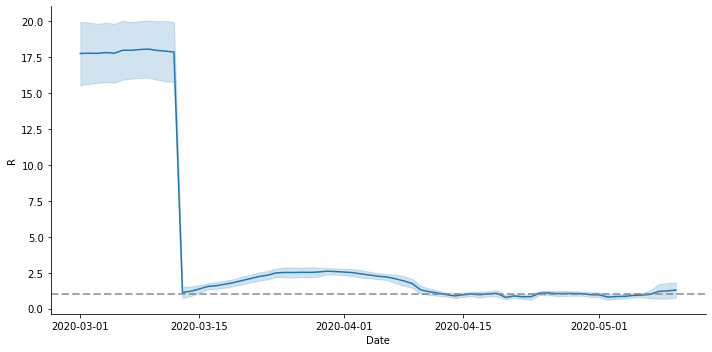

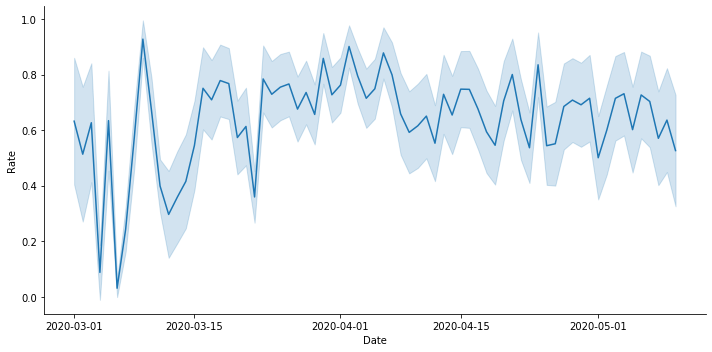

In [35]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_D = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_D}, line=1, name='R_Denmark', value_name='R')
draw({'Detection rate':q}, name='q_Denmark', value_name='Rate')

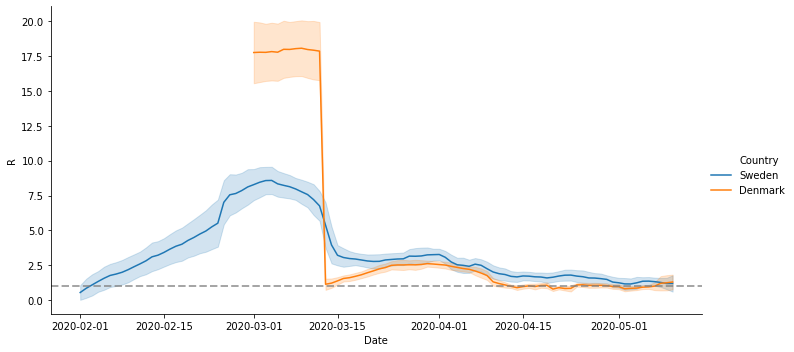

In [36]:
draw({'Sweden':R_S, 'Denmark':R_D,}, line=1, name='R_Nordic', value_name='R', label_name='Country')

In [37]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_1 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer_01 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.1)
infer_001 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.01)
infer_0001 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
                        detection_rate=0.001)
# infer_0 = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration, 
#                         detection_rate=0)
loo = az.loo(infer_1, pointwise=True)
print(az.compare({'1':infer_1, '0.1':infer_01, '0.01':infer_001, '0.001':infer_0001}, ic='loo'))
print(az.compare({'1':infer_1, '0.1':infer_01, '0.01':infer_001, '0.001':infer_0001}, ic='waic'))

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.52    0.02   1.39   0.66   1.52   2.24   3.19   5.99   8356    1.0
b_beta       8.5e-3  2.4e-5 1.5e-3 5.8e-3 7.4e-3 8.3e-3 9.4e-3   0.01   3916    1.0
b[1]           0.06  1.1e-3   0.05 1.2e-3   0.01   0.04    0.1   0.18   2641    1.0
b[2]           0.09  9.1e-4   0.05   0.01   0.05   0.09   0.12   0.19   3060    1.0
b[3]            0.1  8.1e-4   0.05   0.02   0.07    0.1   0.13   0.19   3294    1.0
b[4]           0.11  7.0e-4   0.04   0.03   0.08   0.11   0.14    0.2   3736    1.0
b[5]           0.11  6.3e-4   0.04   0.05   0.09   0.11   0.14    0.2   3945    1.0
b[6]           0.12  5.9e-4   0.04   0.05   0.09   0.12   0.14    0.2   4059    1.0
b[7]           0.12  5.5e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      24.35    0.29  16.95   3.64  11.91  20.34  32.56  67.29   3483    1.0
b_beta       9.8e-3  2.1e-5 1.6e-3 7.0e-3 8.6e-3 9.6e-3   0.01   0.01   6362    1.0
b[1]           0.14  2.8e-3    0.1 2.2e-3   0.04   0.15   0.22   0.34   1310    1.0
b[2]           0.19  1.7e-3   0.08   0.03   0.13   0.18   0.23   0.36   2355    1.0
b[3]           0.19  1.5e-3   0.08   0.06   0.14   0.19   0.24   0.36   2509    1.0
b[4]            0.2  1.4e-3   0.07   0.08   0.15   0.19   0.24   0.36   2539    1.0
b[5]            0.2  1.4e-3   0.07   0.09   0.16   0.19   0.24   0.35   2536    1.0
b[6]            0.2  1.3e-3   0.07    0.1   0.16    0.2   0.24   0.35   2495    1.0
b[7]            0.2  1.3e-3   0.06    0.1   0.16    0

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     256.47    3.99 172.37  23.51  129.2 223.02 345.49 680.69   1865    1.0
b_beta         0.01  2.2e-5 1.7e-3 7.2e-3 8.9e-310.0e-3   0.01   0.01   5887    1.0
b[1]           0.16  8.9e-3   0.14 2.0e-3   0.02   0.15   0.23   0.46    254   1.01
b[2]           0.21  7.8e-3   0.12   0.03   0.14    0.2   0.26   0.48    236   1.01
b[3]           0.22  7.6e-3   0.11   0.06   0.15    0.2   0.26   0.49    223   1.02
b[4]           0.23  7.5e-3   0.11   0.09   0.16   0.21   0.26   0.49    211   1.02
b[5]           0.23  7.5e-3   0.11    0.1   0.17   0.21   0.26   0.48    205   1.02
b[6]           0.23  7.5e-3   0.11   0.11   0.17   0.21   0.26   0.48    200   1.02
b[7]           0.23  7.4e-3    0.1   0.11   0.17   0.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     2306.7   45.95 1656.3  32.68 1113.6 1973.8 3143.0 6428.9   1299    1.0
b_beta         0.01  2.5e-5 1.9e-3 8.6e-3   0.01   0.01   0.01   0.02   5993    1.0
b[1]           0.19    0.02   0.22 2.0e-3   0.03   0.16   0.25   0.93    129   1.03
b[2]           0.25    0.02   0.19   0.04   0.15   0.21   0.28   0.93    121   1.03
b[3]           0.26    0.02   0.19   0.06   0.16   0.22   0.29   0.93    119   1.03
b[4]           0.26    0.02   0.19   0.09   0.17   0.22   0.29   0.93    117   1.03
b[5]           0.27    0.02   0.18    0.1   0.18   0.23   0.29   0.93    115   1.03
b[6]           0.27    0.02   0.18   0.11   0.18   0.23   0.29   0.93    114   1.03
b[7]           0.27    0.02   0.18   0.12   0.18   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with 

      rank      loo    p_loo    d_loo     weight       se      dse warning  \
1        0  802.455  95.3484        0    0.72122  38.2662        0    True   
0.1      1  810.628  91.6503  8.17306   0.234056  40.7457  13.0187    True   
0.001    2   816.85  95.8343  14.3953  0.0275262  42.1594  13.1453    True   
0.01     3  817.814  94.5186  15.3591   0.017198  42.2771    13.58    True   

      loo_scale  
1      deviance  
0.1    deviance  
0.001  deviance  
0.01   deviance  
      rank     waic   p_waic    d_waic     weight       se      dse warning  \
0.1      0  747.473  60.0724         0   0.278028  38.6339        0    True   
1        1  748.048   68.145  0.575731   0.531854  37.3667  20.1339    True   
0.001    2  750.676  62.7472   3.20382   0.110537  38.1804  3.08569    True   
0.01     3   751.03  61.1263   3.55734  0.0795818  38.6716  1.67784    True   

      waic_scale  
0.1     deviance  
1       deviance  
0.001   deviance  
0.01    deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


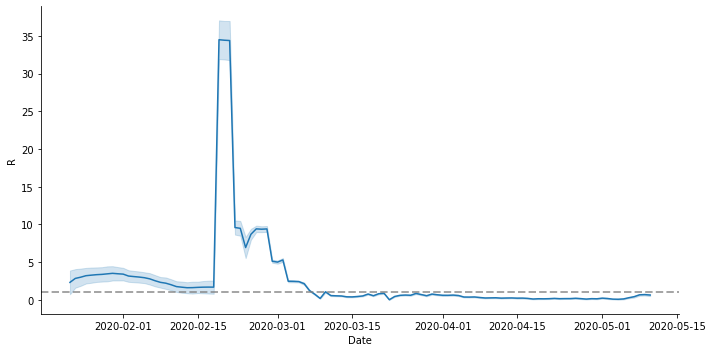

In [38]:
infer=infer_1
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K1 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K1}, line=1, name='R_Korea1', value_name='R')

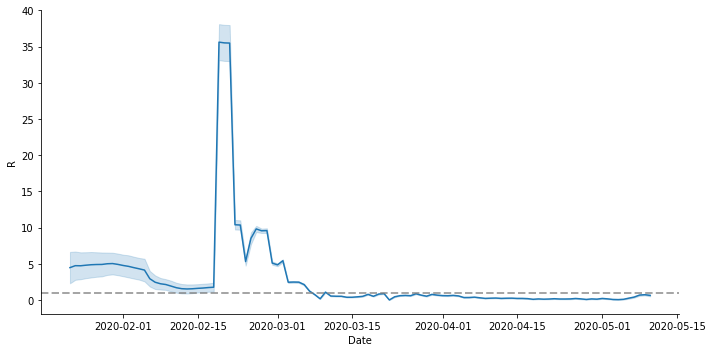

In [39]:
infer=infer_01
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K01 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K01}, line=1, name='R_Korea01', value_name='R')

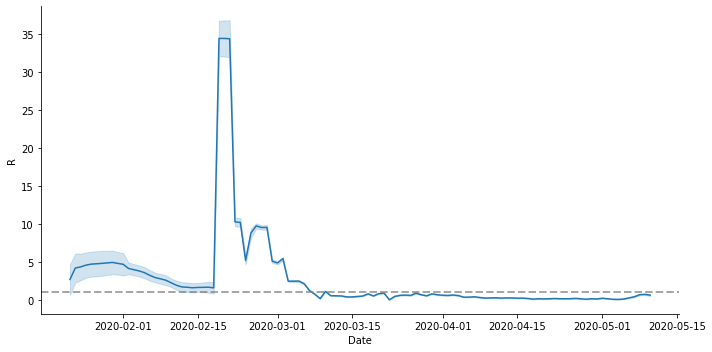

In [40]:
infer=infer_001
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K001 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K001}, line=1, name='R_Korea001', value_name='R')

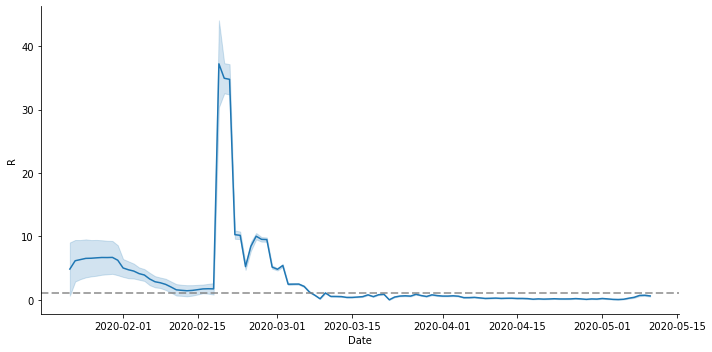

In [41]:
infer=infer_0001
beta = extract_var(var_name='b', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K0001 = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K0001}, line=1, name='R_Korea0001', value_name='R')

In [42]:
az.compare({'1':infer_1, '0.1':infer_01, '0.01':infer_001, '0.001':infer_0001}, ic='loo')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
1,0,802.455,95.3484,0,0.715815,41.2068,0,True,deviance
0.1,1,810.628,91.6503,8.17306,0.238399,42.6674,13.0187,True,deviance
0.001,2,816.85,95.8343,14.3953,0.0285445,44.4866,13.1453,True,deviance
0.01,3,817.814,94.5186,15.3591,0.0172407,44.6013,13.58,True,deviance
